## Projet Data Science – Mastère 2 

* Nom: AMGHAR Younes

***

# Introduction

Airbnb est une plateforme de partage de maison qui permet aux propriétaires et aux locataires (les "hôtes") de mettre leurs annonces en ligne, afin que les clients puissent payer pour y séjourner. Les hôtes sont censés fixer leurs propres prix pour leurs annonces. Bien qu'Airbnb et d'autres sites fournissent des conseils généraux, il n'existe actuellement aucun service gratuit pour aider les hôtes à fixer le prix de leurs propriétés. Des logiciels de tarification tiers payants sont disponibles, mais vous devez généralement indiquer votre propre prix moyen prévu ("prix de base"), et l'algorithme fera varier le prix quotidien autour de ce prix de base chaque jour en fonction du jour de la semaine, de la saisonnalité, de l'éloignement de la date et d'autres facteurs.

Il est important de bien fixer les prix d'Airbnb, en particulier dans les grandes villes comme Paris où il y a beaucoup de concurrence et où même de petites différences de prix peuvent faire la différence entre un taux d'occupation optimal et des revenus élevés, ou être exclu du marché. Il est également difficile de faire les choses correctement, afin d'équilibrer le prix et l'occupation (qui varie inversement au prix) pour maximiser les revenus.


***

***

# Cleaning and pre-processing

### Importing the libraries and data

In [4]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
# import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import SGDRegressor

In [5]:
raw_df = pd.read_csv('listings.csv')
print(f"Le Dataset contient {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

Le Dataset contient 65917 Airbnb listings


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2577,https://www.airbnb.com/rooms/2577,20201214191425,2020-12-16,Loft for 4 by Canal Saint Martin,"100 m2 loft (1100 sq feet) with high ceiling, ...",NaN,https://a0.muscache.com/pictures/09da057c-0120...,2827,https://www.airbnb.com/users/show/2827,Karine,2008-09-09,"Casablanca, Grand Casablanca, Morocco","Arrivée à Casablanca il y a 4 ans, je suis amo...",NaN,NaN,67%,f,https://a0.muscache.com/im/pictures/user/17fe6...,https://a0.muscache.com/im/pictures/user/17fe6...,République,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,Entrepôt,NaN,48.86993,2.36251,Entire loft,Entire home/apt,4,NaN,2 baths,2.0,2.0,"[""Dryer"", ""Host greets you"", ""Hot water"", ""Han...",$125.00,3,1125,3.0,3.0,1125.0,1125.0,3.0,1125.0,NaN,t,30,60,90,364,2020-12-16,1,0,0,2019-01-02,2019-01-02,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f,1,1,0,0,0.04
1,3109,https://www.airbnb.com/rooms/3109,20201214191425,2020-12-17,zen and calm,<b>The space</b><br />I bedroom appartment in ...,Good restaurants<br />very close the Montparna...,https://a0.muscache.com/pictures/baeae9e2-cd53...,3631,https://www.airbnb.com/users/show/3631,Anne,2008-10-14,"Paris, Île-de-France, France",NaN,NaN,NaN,0%,f,https://a0.muscache.com/im/users/3631/profile_...,https://a0.muscache.com/im/users/3631/profile_...,Alésia,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Paris, Île-de-France, France",Observatoire,NaN,48.83349,2.31852,Entire apartment,Entire home/apt,2,NaN,1 bath,NaN,1.0,"[""Children\u2019s books and toys"", ""Paid parki...",$60.00,2,30,2.0,2.0,30.0,30.0,2.0,30.0,NaN,t,2,2,2,2,2020-12-17,9,0,0,2016-12-27,2019-10-24,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f,1,1,0,0,0.19
2,4890,https://www.airbnb.com/rooms/4890,20201214191425,2020-12-16,Quiet Historic & Cute +Free Cruise,Stylish & Classic One bedroom apartment for up...,"Called ""Paris Next Great Neighborhood"" from Tr...",https://a0.muscache.com/pictures/b144894f-bc55...,6792,https://www.airbnb.com/users/show/6792,Ryan Of Cobblestone,2009-01-16,"Paris, Île-de-France, France",I am the owner of Cobblestone Paris Rentals\r\...,within an hour,100%,100%,f,https://a0.muscache.com/im/users/6792/profile_...,https://a0.muscache.com/im/users/6792/profile_...,Le Marais,9.0,9.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Paris, Ile-de-France, France",Temple,NaN,48.86409,2.35651,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,2.0,"[""Dryer"", ""Host greets you"", ""Hangers"", ""Iron""...",$69.00,5,120,5.0,5.0,1125.0,1125.0,5.0,1125.0,NaN,t,8,37,67,67,2020-12-16,23,1,0,2011-11-22,2020-09-07,95.0,10.0,9.0,10.0,10.0,10.0,10.0,NaN,f,14,14,0,0,0.21


### Dropping initial columns

Les colonnes de texte libre seront abandonnées pour l'instant, tout comme d'autres colonnes qui ne sont pas utiles pour prédire le prix (par exemple, l'url, le nom de l'hôte et d'autres caractéristiques liées à l'hôte qui ne sont pas liées à la propriété).

In [6]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview','picture_url','host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

D'autres colonnes peuvent être abandonnées car elles contiennent une majorité d'entrées nulles.

In [7]:
df.isna().sum()

id                                                  0
host_since                                         28
host_response_time                              42291
host_response_rate                              42291
host_acceptance_rate                            29704
host_is_superhost                                  28
host_listings_count                                28
host_total_listings_count                          28
host_has_profile_pic                               28
host_identity_verified                             28
neighbourhood                                   26266
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                    65917
latitude                                            0
longitude                                           0
property_type                                       0
room_type                                           0
accommodates                                        0
bathrooms                   

In [8]:
df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed','license'], axis=1, inplace=True)

df.set_index('id', inplace=True) # The id will be used as the index, as this could be useful in future e.g. if a separate dataset containing reviews for each property is linked to this one

host_listings_count et host_total_listings_count sont les mêmes dans tous les cas sauf 28. Ces cas sont ceux où la valeur est NaN. Par conséquent, une de ces colonnes peut être abandonnée. D'autres colonnes qui divisent ces derniers par type de propriété seront également abandonnées, car elles seront fortement corrélées (l'une sera le total des autres).

In [9]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:5]

28


,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
618419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Paris, Île-de-France, France",Popincourt,48.86507,2.38442,Private room in apartment,Private room,2,NaN,1 shared bath,1.0,1.0,"[""Ethernet connection"", ""Oven"", ""Paid parking ...",$60.00,5,1001,5.0,5.0,1001.0,1001.0,5.0,1001.0,NaN,t,0,0,0,0,71,0,0,2016-12-15,2019-07-10,94.0,10.0,9.0,9.0,9.0,9.0,9.0,f,1,0,1,0,1.46
2672598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Paris, Île-de-France, France",Temple,48.85703,2.36412,Entire apartment,Entire home/apt,2,NaN,1 bath,NaN,2.0,"[""Lockbox"", ""Paid parking off premises"", ""Carb...",$60.00,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,30,60,89,90,278,28,0,2014-05-19,2020-10-08,86.0,9.0,8.0,10.0,10.0,10.0,9.0,f,1,1,0,0,3.47
5872399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entrepôt,48.87250,2.37467,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Kitchen"", ""Washer"", ""Wifi"", ""Heating""]",$57.00,1,1125,1.0,1.0,1125.0,1125.0,1.0,1125.0,NaN,t,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,2,2,0,0,NaN
5987708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Paris, Île-de-France, France",Ménilmontant,48.87116,2.38245,Entire apartment,Entire home/apt,6,NaN,1 bath,2.0,3.0,"[""Kitchen"", ""Heating"", ""Essentials"", ""TV"", ""Wa...",$120.00,7,57,7.0,7.0,57.0,57.0,7.0,57.0,NaN,t,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
6085826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Opéra,48.87999,2.33673,Entire apartment,Entire home/apt,2,NaN,1 bath,NaN,1.0,"[""Fire extinguisher"", ""Wifi"", ""Smoke alarm"", ""...",$55.00,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,0,0,0,0,32,0,0,2015-05-28,2016-10-10,86.0,9.0,10.0,10.0,10.0,10.0,9.0,f,1,1,0,0,0.47


In [10]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

In [11]:
lat_long = df[['latitude', 'longitude']]

In [12]:
df.drop(['latitude', 'longitude','neighbourhood' ], axis=1, inplace=True)

Il existe plusieurs colonnes pour les nuitées minimales et maximales, mais les deux principales seront utilisées car il y a peu de différences entre, par exemple, minimum_nights et minimum_minimum_nights. Ce dernier fait vraisemblablement référence au fait que les nuitées minimales et maximales peuvent varier au cours de l'année.

In [13]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)

2110

En explorant le jeu de données, on remarque aussi que l'informations de salle de bain est mal formatée. 
En effet le nombre et le type de la salle de bain sont tous les deux dans la même colonne comme vous pouvez le voir ci-dessous.
Je vais donc spliter l'information en deux colonnes.

In [14]:
df["bathroom_qty"] = df["bathrooms_text"].str.split(" ", expand=True)[0]
df["bathroom_type"] = df["bathrooms_text"].str.split(" ", expand=True)[1]
df[["bathroom_qty","bathroom_type"]].head()

,bathroom_qty,bathroom_type
id,,
2577,2,baths
3109,1,bath
4890,1,bath
5396,1,bath
7397,1,bath


In [15]:
df.drop(['bathroom_type', 'bathrooms_text'], axis=1, inplace=True)

In [16]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

Vérifier si les caractéristiques booléennes et catégorielles contiennent un nombre suffisant d'instances dans chaque catégorie pour qu'il vaille la peine de les inclure

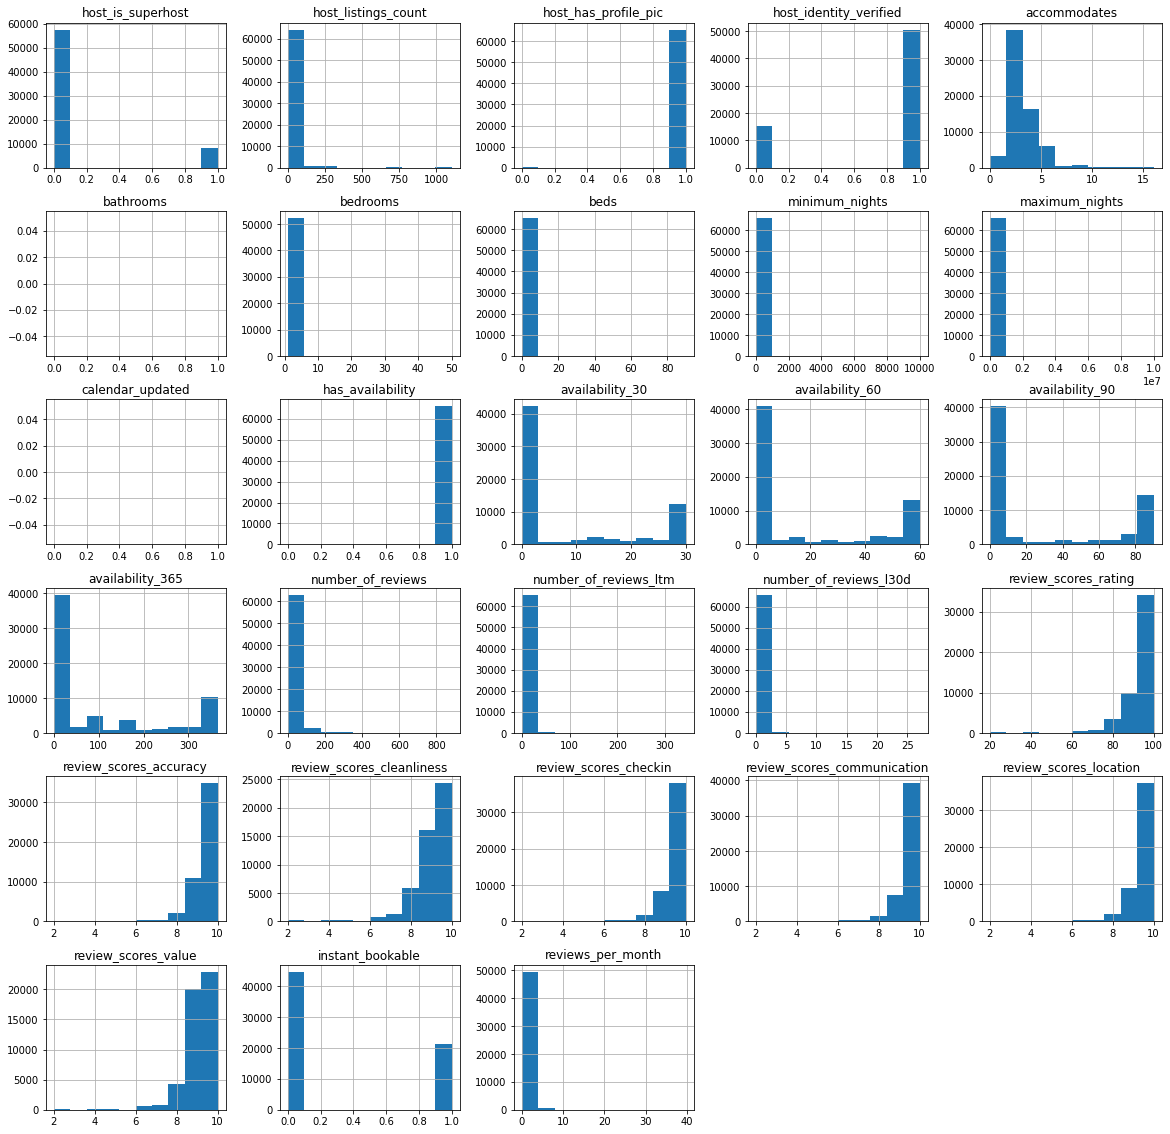

In [17]:
df.replace({'f': 0, 't': 1}, inplace=True)
df.hist(figsize=(20,20));

In [18]:
df.drop(['has_availability', 'host_has_profile_pic','bathrooms'], axis=1, inplace=True)

### Cleaning individual columns

**host_since**

In [19]:
df.host_since = pd.to_datetime(df.host_since) 

df['host_days_active'] = (datetime(2022, 1, 31) - df.host_since).astype('timedelta64[D]')

print("Temps moyens comme hoet:", round(df['host_days_active'].mean(),0))
print("Temps médiane comme hote:", df['host_days_active'].median())

df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Temps moyens comme hoet: 2278.0
Temps médiane comme hote: 2397.0


In [20]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

Null values: 42291
Proportion: 64.2%


In [21]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

unknown               0.641580
within an hour        0.194017
within a day          0.071727
within a few hours    0.062609
a few days or more    0.030068
Name: host_response_time, dtype: float64

In [22]:
df.host_response_time.value_counts(normalize=True)

unknown               0.641580
within an hour        0.194017
within a day          0.071727
within a few hours    0.062609
a few days or more    0.030068
Name: host_response_time, dtype: float64

**host_response_rate**

Il en va de même pour host_response_rate, avec environ un tiers des valeurs qui sont nulles. Cette valeur sera également conservée comme sa propre catégorie, après avoir regroupé les autres valeurs en groupes significatifs (c'est-à-dire en la transformant en une caractéristique catégorielle, plutôt que numérique). Étant donné qu'environ 70 % des hôtes répondent 100 % du temps, cette valeur sera conservée comme une catégorie à part entière, et les autres valeurs seront regroupées dans des catégories.

In [23]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 42291
Proportion: 64.2%


In [24]:

df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Moyenne reponse de hote:", round(df['host_response_rate'].mean(),0))
print("Median response:", df['host_response_rate'].median())
print(f"Proportion de  100% de reponse d'hote  : {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Moyenne reponse de hote: 88.0
Median response: 100.0
Proportion de  100% de reponse d'hote  : 64.4%


In [25]:
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

df.host_response_rate = df.host_response_rate.astype('str')

df.host_response_rate.replace('nan', 'unknown', inplace=True)

df.host_response_rate.value_counts()

unknown    42291
100%       15206
50-89%      3732
0-49%       2463
90-99%      2225
Name: host_response_rate, dtype: int64

**host_is_superhost**

In [26]:
df.dropna(subset=['host_since'], inplace=True)

**property_type**

Un certain nettoyage des types de propriétés est nécessaire car il existe un grand nombre de catégories avec seulement quelques listes. Les catégories "appartement", "maison" et "autre" seront utilisées, car la plupart des propriétés peuvent être classées comme appartements ou maisons.

In [27]:
df.property_type.value_counts()

Entire apartment                      52739
Private room in apartment              5607
Entire condominium                     1797
Room in boutique hotel                 1729
Entire loft                            1116
Room in hotel                           508
Entire house                            352
Private room in condominium             296
Shared room in apartment                293
Entire serviced apartment               171
Entire townhouse                        162
Private room in bed and breakfast       134
Private room in house                   113
Private room in loft                     94
Room in aparthotel                       80
Private room in townhouse                74
Room in serviced apartment               65
Shared room in hostel                    53
Private room in guesthouse               51
Entire place                             43
Entire guesthouse                        40
Private room in hostel                   40
Room in hostel                  

In [28]:
df.property_type.replace({
    'Entire house': 'House',
    'Entire apartment ': 'Apartment',
    'Private room in apartment': 'Apartment',
    'Shared room in apartment' : 'Apartment',
    'Private room in house': 'House',
    'Entire condominium ': 'House',
    'Private room in condominium': 'House'
    }, inplace=True)

df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

**bathrooms, bedrooms , beds**

Les valeurs manquantes seront remplacées par la médiane (pour éviter les fractions étranges).

In [29]:
df.bathroom_qty.replace({'Half-bath' : 0.5,'Shared' : 0.5, 'Private' : 1}, inplace=True)

In [30]:
for col in ['bathroom_qty', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

**amenities**

In [31]:
df.amenities[:1].values

array(['["Dryer", "Host greets you", "Hot water", "Hangers", "Iron", "Wifi", "Dedicated workspace", "Heating", "TV", "Washer", "Essentials", "Kitchen"]'],
      dtype=object)

In [32]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('[', '')
amenities_list_string = amenities_list_string.replace(']', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '100\\ HDTV with Netflix',
 '2 Plaques \\u00e9lectriques electric stove',
 '2 fours: Micro-onde et chaleur tournante stainless steel oven',
 '2 r\\u00e9frig\\u00e9rateur encastr\\u00e9s refrigerator',
 '2-5 years old',
 '23\\ HDTV with premium cable',
 '23\\ TV with Netflix',
 '24-hour fitness center',
 '24\\ HDTV',
 '32\\ HDTV',
 '32\\ HDTV with Amazon Prime Video',
 '32\\ HDTV with Netflix',
 '32\\ TV',
 '35\\ HDTV with standard cable',
 '40\\ HDTV',
 '40\\ HDTV with Netflix',
 '40\\ HDTV with standard cable',
 '42\\ HDTV with Netflix',
 '43\\ HDTV with Netflix',
 '45\\ HDTV with premium cable',
 '5-10 years old',
 '55\\ HDTV',
 '55\\ HDTV with Netflix',
 '55\\ HDTV with premium cable',
 '65\\ HDTV with Netflix',
 '65\\ HDTV with premium cable',
 '7 Plantes Cien shampoo',
 'A la r\\u00e9ception refrigerator',
 'A la reception refrigerator',
 'A partager refrigerator',
 'AESOP shampoo',
 'Aesop conditioner',
 'Aesop shampoo',
 'Air conditioning',
 'Airplay / Chromecast speaker s

Comme il y a trop de possibilités, nous allons catégorisé les données. Ceux choisis sont : 


In [33]:
df.loc[df['amenities'].str.contains('Air conditioning|Central air'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon|Game|Netflix|Projector|Smart TV|Sound system|DVD|Chromecast|Projector'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('oven'), 'oven'] = 1
df.loc[df['amenities'].str.contains('BBQ|Barbecue|grill'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach|Beachfront|Lake access|Mountain view|Ski|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV|HDTV|tv|Tv|Cable'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee|Espresso'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics|Kitchen|Kitchenette'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('2-5 years old|Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool|steam'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1


C:\Users\oulad\AppData\Local\Temp/ipykernel_16692/1498505585.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1


Une façon de réduire le nombre de caractéristiques (afin d'éviter le probleme de la dimensionnalité) est de supprimer les amenties qui ajoutent relativement peu d'informations, ou qui sont relativement peu utiles pour différencier les différents listings. Les caractéristiques d'agrément dont la catégorie vraie ou fausse contient moins de 10% des listings seront supprimées.

In [34]:
df.columns[37:]

Index(['air_conditioning', 'high_end_electronics', 'oven', 'bbq', 'balcony',
       'nature_and_views', 'bed_linen', 'breakfast', 'tv', 'coffee_machine',
       'cooking_basics', 'white_goods', 'elevator', 'gym', 'child_friendly',
       'parking', 'outdoor_space', 'host_greeting', 'hot_tub_sauna_or_pool',
       'internet', 'long_term_stays', 'pets_allowed', 'private_entrance',
       'secure', 'self_check_in', 'smoking_allowed', 'accessible',
       'event_suitable'],
      dtype='object')

In [35]:
cols_to_replace_nulls = df.iloc[:,37:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

infrequent_amenities = []
for col in df.iloc[:,37:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

df.drop(infrequent_amenities, axis=1, inplace=True)

df.drop('amenities', axis=1, inplace=True)

['air_conditioning', 'high_end_electronics', 'oven', 'bbq', 'balcony', 'nature_and_views', 'gym', 'child_friendly', 'outdoor_space', 'hot_tub_sauna_or_pool', 'pets_allowed', 'secure', 'self_check_in', 'smoking_allowed', 'accessible', 'event_suitable']


In [36]:
df.columns[37:]

Index(['breakfast', 'tv', 'coffee_machine', 'cooking_basics', 'white_goods',
       'elevator', 'parking', 'host_greeting', 'internet', 'long_term_stays',
       'private_entrance'],
      dtype='object')

**price**

On doit convertir le prix à un int

In [37]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

Calender updated 

In [38]:
df.drop('calendar_updated', axis=1, inplace=True)

**availability**

In [39]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

**first_review and last_review**

Environ un quart des annonces n'ont pas fait l'objet d'une critique. Il s'agit d'une proportion trop importante de l'ensemble de données pour être abandonnée, et l'abandon des colonnes ferait perdre beaucoup d'informations utiles - les avis sont très importants dans la décision des gens de réserver, et donc dans le prix.

Il s'agit également d'une proportion trop importante de l'ensemble de données pour être simplement remplacée par des valeurs médianes/moyennes, car cela fausserait considérablement la distribution. De plus, les valeurs manquantes ne sont pas vraiment des valeurs manquantes, car le fait qu'il s'agisse de valeurs NaN est significatif - cela nous indique qu'il s'agit de nouvelles inscriptions ou d'inscriptions non réservées qui n'ont pas encore fait l'objet d'évaluations. Pour que le modèle résultant soit capable de prédire les prix de n'importe quelle annonce Airbnb, y compris les toutes nouvelles annonces, il est en fait bénéfique de les conserver. Par conséquent, elles seront conservées dans la catégorie "inconnu" et la caractéristique devra être traitée comme une catégorie (et donc codée en un point) plutôt que numérique.

In [40]:
print(f"valeur nulle dans 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"valeur nulle dans 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 23.8%
Null values in 'review_scores_rating': 25.6%


In [41]:
df.first_review = pd.to_datetime(df.first_review) 

df['time_since_first_review'] = (datetime(2019, 4, 9) - df.first_review).astype('timedelta64[D]')

In [42]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Prend un nom de colonne, des points de découpage et des labels, remplace la colonne originale par une version binnée et remplace les nuls (par "unknown" si non spécifié).
    version classée, et remplace les nuls (par 'unknown' si non spécifié).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [43]:
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

Même pour last review

In [44]:
df.last_review = pd.to_datetime(df.last_review) 

df['time_since_last_review'] = (datetime(2019, 4, 9) - df.last_review).astype('timedelta64[D]')

In [45]:
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [46]:
df.drop('last_review', axis=1, inplace=True)

**review ratings columns**

Comme ci-dessus, les listes sans avis seront conservées et remplacées par "inconnu". Les autres évaluations seront regroupées dans des catégories. Les histogrammes ci-dessous ont été produits afin de déterminer les catégories utiles. La majorité des évaluations sont de 9 ou 10 sur 10, comme le montre également le décompte des valeurs ci-dessous. Par conséquent, pour ces colonnes, 9/10 et 10/10 seront conservés en tant que groupes séparés, et 1-8/10 seront regroupés (car il s'agit, selon les normes d'Airbnb, d'une évaluation "faible").

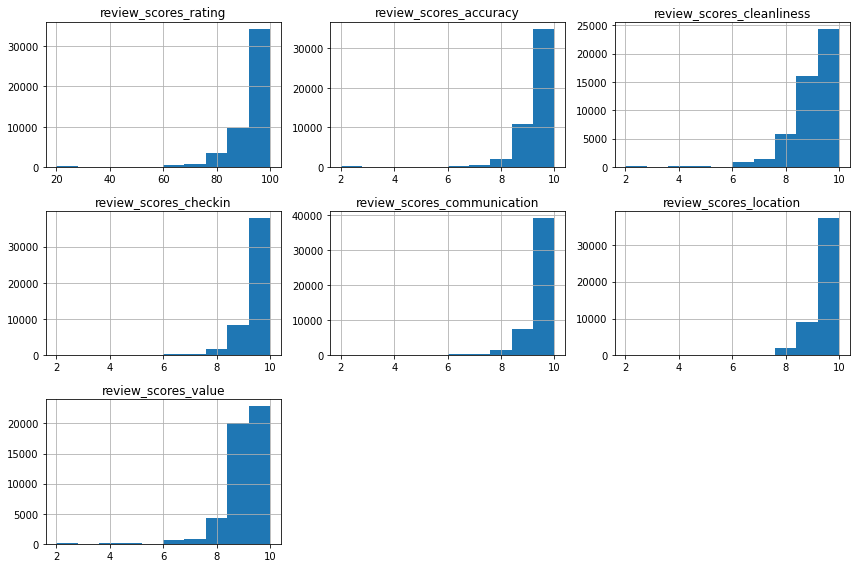

In [47]:
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [48]:
variables_to_plot.pop(0)

'review_scores_rating'

In [49]:
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [50]:
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

**number_of_reviews_ltm and reviews_per_month**

Ceux-ci seront fortement corrélés avec le number_of_reviews et seront donc abandonnés.

In [51]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

***

# Analyse de données

### L'HOTE 

In [52]:
sns.set_theme(font_scale=1.5, style="darkgrid")

In [53]:
df.head()

,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_90,number_of_reviews,number_of_reviews_l30d,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,bathroom_qty,host_days_active,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,parking,host_greeting,internet,long_term_stays,private_entrance,time_since_first_review,time_since_last_review
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2577,2008-09-09,unknown,unknown,0.0,2.0,1.0,Entrepôt,Other,Entire home/apt,4,2.0,2.0,125,3,1125,90,1,0,2019-01-02,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,0,2,4892.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0-6 months,2-6 months
3109,2008-10-14,unknown,unknown,0.0,1.0,0.0,Observatoire,Other,Entire home/apt,2,1.0,1.0,60,2,30,2,9,0,2016-12-27,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,0,1,4857.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2-3 years,nan
4890,2009-01-16,within an hour,100%,0.0,9.0,1.0,Temple,Other,Entire home/apt,4,1.0,2.0,69,5,120,67,23,0,2011-11-22,80-94/100,10/10,9/10,10/10,10/10,10/10,10/10,0,1,4763.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4+ years,nan
5396,2009-02-14,within an hour,100%,0.0,1.0,1.0,Hôtel-de-Ville,Other,Entire home/apt,2,1.0,1.0,62,1,1125,90,231,0,2009-06-30,80-94/100,9/10,9/10,9/10,10/10,10/10,0-8/10,0,1,4734.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,4+ years,nan
7397,2008-08-30,within an hour,100%,1.0,3.0,1.0,Hôtel-de-Ville,Other,Entire home/apt,4,2.0,2.0,53,15,130,73,269,0,2011-04-08,80-94/100,10/10,9/10,10/10,10/10,10/10,10/10,0,1,4902.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,4+ years,nan


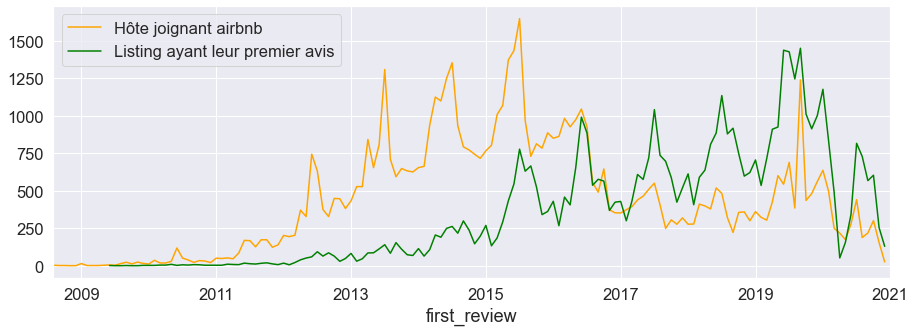

In [54]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot(label='Hôte joignant airbnb', color='orange')
df.set_index('first_review').resample('MS').size().plot(label='Listing ayant leur premier avis', color='green')
plt.legend()
plt.xlim('2008-08-01', '2021-01-31')
plt.show()

In [55]:

ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [56]:
def decompose_time_series(df, title=''):
   
    decomposition = seasonal_decompose(df)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

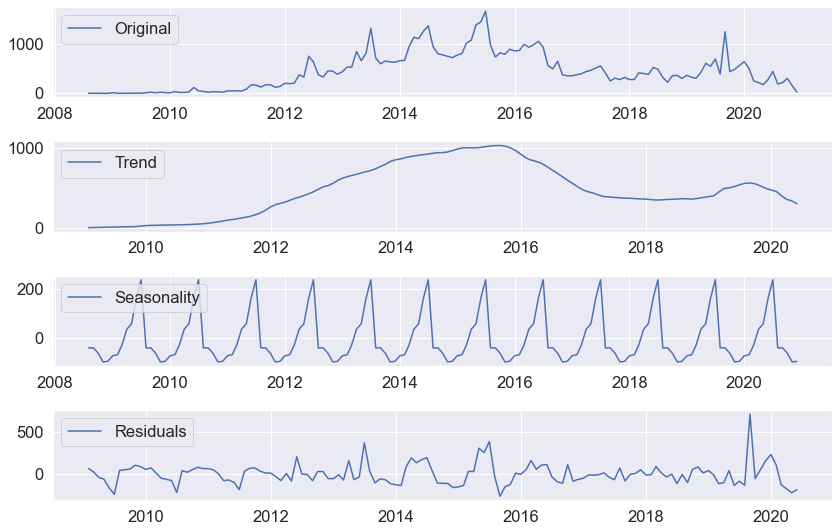

In [57]:
decompose_time_series(ts_host_since)

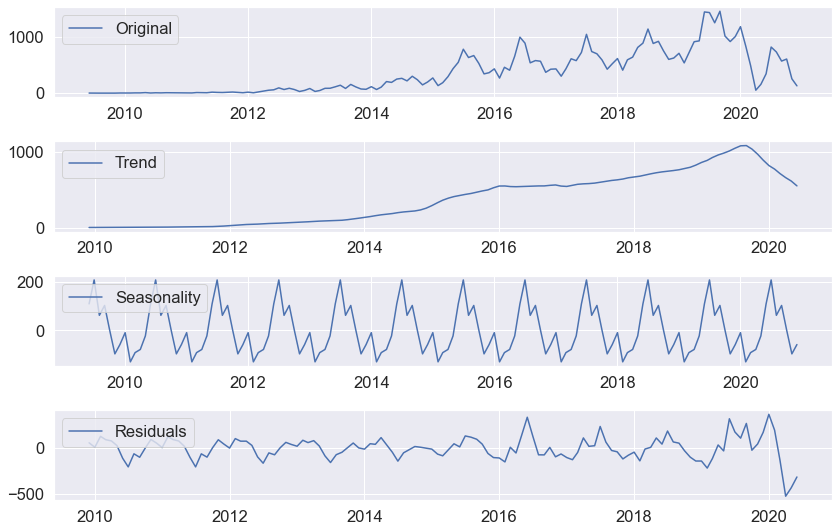

In [58]:
decompose_time_series(ts_first_review)

In [59]:
df.groupby(["host_identity_verified"], as_index=False).agg(avg_price=("price", "mean"),qty=("price", "count"))

,host_identity_verified,avg_price,qty
0,0.0,105.231120,15334
1,1.0,117.031431,50555


In [60]:
df.groupby(
    ["host_response_time"], as_index=False
).agg(
    avg_price = ("price","mean"),
    qty = ("price","count")
).sort_values(
    by="avg_price", ascending=False
).reset_index(drop=True)

,host_response_time,avg_price,qty
0,within a day,141.985195,4728
1,within an hour,139.747987,12789
2,within a few hours,138.709959,4127
3,a few days or more,137.345610,1982
4,unknown,100.014670,42263


on remarque que le fait que le hôte soit vérifié ou pas influe de peu de sur le prix.
Même analyse pour le temps de réponse des hôtes 

### features numérique

In [61]:
df.describe()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_90,number_of_reviews,number_of_reviews_l30d,instant_bookable,host_days_active,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,parking,host_greeting,internet,long_term_stays,private_entrance
count,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000,6.588900e+04,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000,65889.000000
mean,0.125013,11.608690,0.767275,3.046806,1.294040,1.670340,114.285207,5.657302,8.520238e+02,27.628800,18.781208,0.059782,0.323104,2277.820486,0.364674,0.132602,0.667820,0.372642,0.932280,0.780024,0.377483,0.247143,0.178998,0.937729,0.159814,0.146701
std,0.330736,71.594048,0.422571,1.588597,0.858839,1.295554,220.194777,44.289293,3.896231e+04,37.787414,40.671648,0.429909,0.467666,860.084654,0.481342,0.339146,0.470999,0.483512,0.251267,0.414233,0.484761,0.431354,0.383354,0.241650,0.366436,0.353811
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,413.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,59.000000,1.000000,3.000000e+01,0.000000,1.000000,0.000000,0.000000,1693.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,80.000000,2.000000,1.125000e+03,0.000000,5.000000,0.000000,0.000000,2397.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,2.000000,1.000000,4.000000,1.000000,2.000000,120.000000,4.000000,1.125000e+03,74.000000,18.000000,0.000000,1.000000,2884.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1105.000000,1.000000,16.000000,50.000000,90.000000,11600.000000,9999.000000,1.000000e+07,90.000000,882.000000,27.000000,1.000000,4902.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Prix**

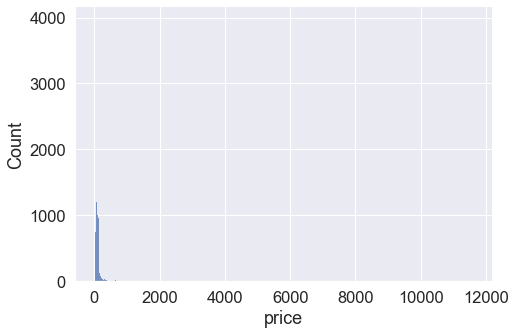

In [62]:
sns.displot(data=df, x="price", kind="hist", aspect=1.5)

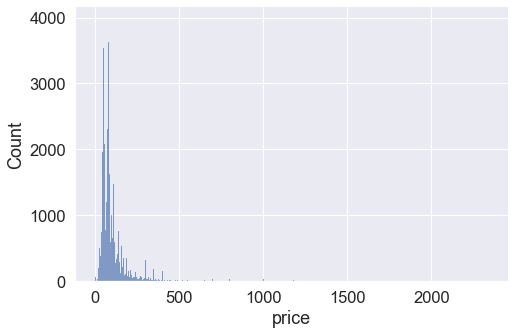

In [63]:
df = df[df.price<2500]
sns.displot(data=df, x="price", kind="hist", aspect=1.5)

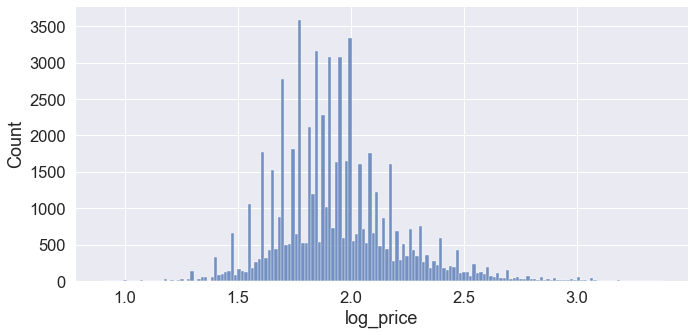

In [64]:
df = df[df.price!=0]
df.loc[:,"log_price"] = np.log10(df.loc[:,"price"])
sns.displot(data=df, x="log_price", kind="hist", aspect=2)

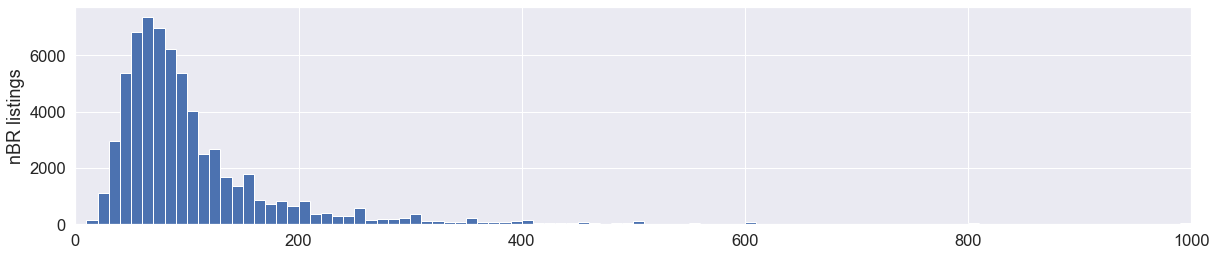

In [65]:
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.ylabel("nBR listings")
plt.show()

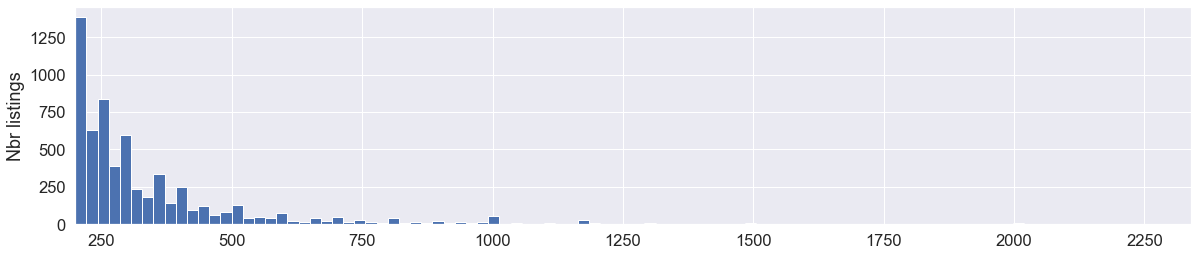

In [66]:
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(200, max(df.price)))
plt.margins(x=0)
plt.ylabel("Nbr listings")
plt.show()

In [67]:
df.loc[df.price <= 20, 'price'] = 20
df.loc[df.price >= 1000, 'price'] = 1000

**Hostcount**

In [68]:
print("Nbr médian de listings par hote:", int(df.host_listings_count.median()))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Nbr médian de listings par hote: 1
59% of listings are from hosts with one listing.


**Nombre de personnes hébergées, salles de bains, chambres et lits**

*Question : quel est le nombre moyen de personnes hébergées, de salles de bain, de chambres et de lits dans les annonces Airbnb à Paris, et comment les prix diffèrent-ils ?

Réponse : la configuration la plus courante des propriétés permet d'accueillir deux personnes dans un lit, dans une chambre, avec une salle de bain. Sans surprise, les propriétés qui accueillent plus de personnes obtiennent des prix à la nuitée sensiblement plus élevés, avec des rendements décroissants après environ 11 personnes.

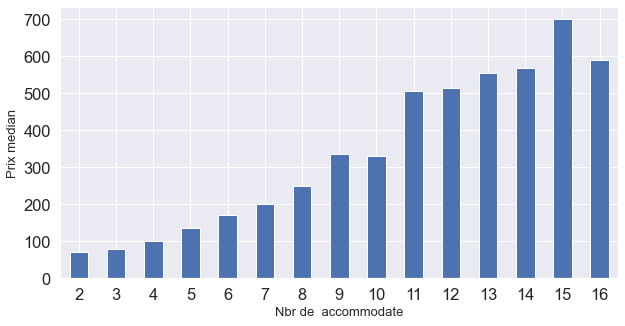

In [69]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('', fontsize=14)
plt.xlabel('Nbr de  accommodate', fontsize=13)
plt.ylabel('Prix median', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

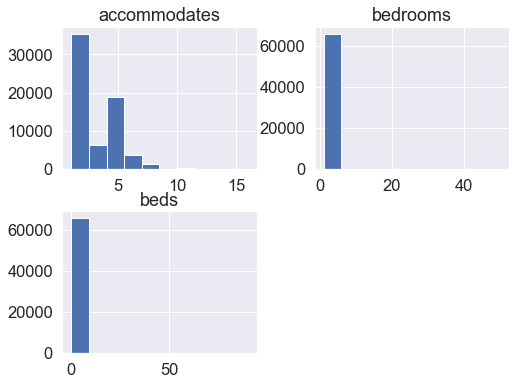

In [70]:
df[['accommodates', 'bedrooms', 'beds']].hist(figsize=(8,6));

### Categorical features

Categorical features will be explored and plotted, to gain insights and to determine whether or not they should be included in the final model.

**Property and room types**

In [71]:
def category_count_plot(col, figsize=(8,4)):
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

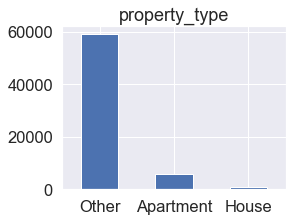

Other        0.898799
Apartment    0.089661
House        0.011540
Name: property_type, dtype: float64


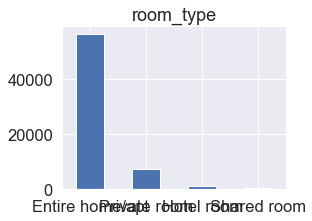

Entire home/apt    0.859343
Private room       0.114019
Hotel room         0.020268
Shared room        0.006371
Name: room_type, dtype: float64


In [72]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(df[col].value_counts(normalize=True))

**Reviews**

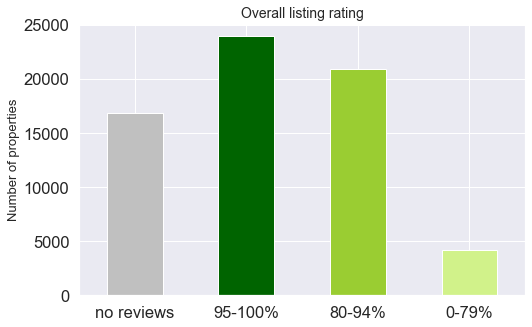

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Overall listing rating', fontsize=14)
df['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['silver', 'darkgreen', 'yellowgreen', '#d1f28a' ], ax=ax)
ax.set_xticklabels(labels=['no reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Number of properties', fontsize=13)
plt.show()

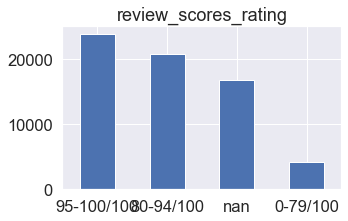

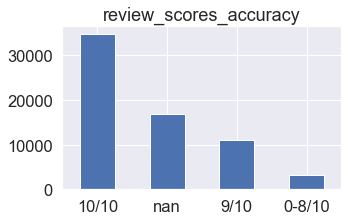

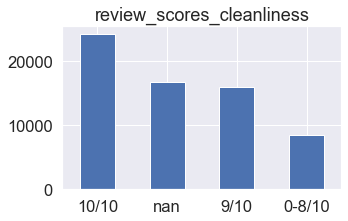

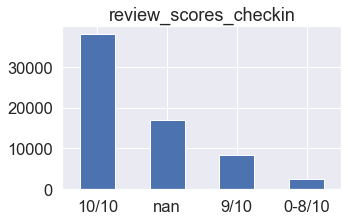

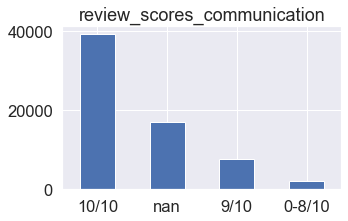

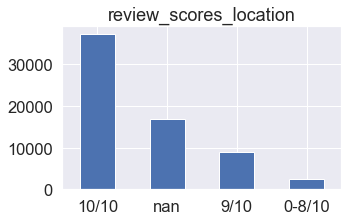

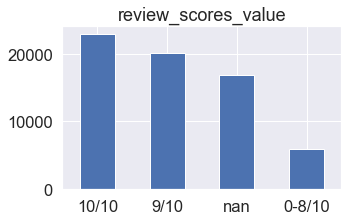

In [74]:
for col in list(df.columns[df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

**First and last reviews**

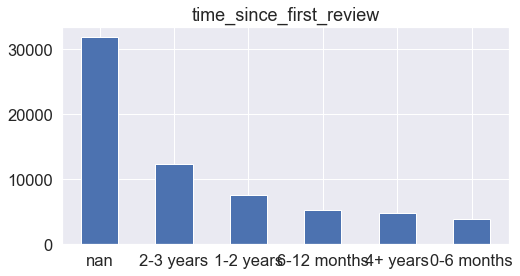

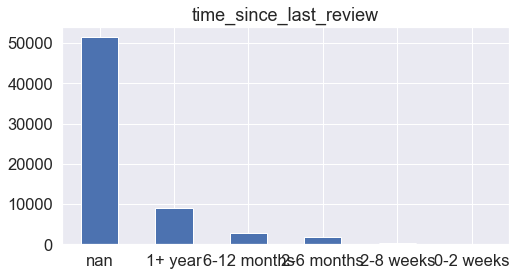

In [75]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

### Boolean (true or false) features

In [76]:
def binary_count_and_price_plot(col, figsize=(8,3)):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) 
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Prix médian')
    ax2.set_xlabel('')
    
    plt.show()

**Superhosts**

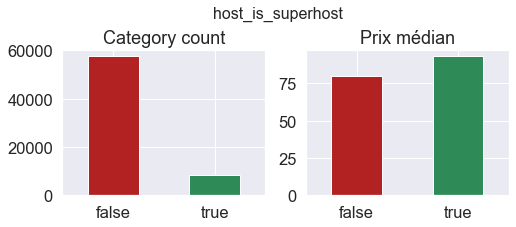

0.0    0.874806
1.0    0.125194
Name: host_is_superhost, dtype: float64


In [77]:
binary_count_and_price_plot('host_is_superhost')
print(df.host_is_superhost.value_counts(normalize=True))

**Host verification**

In [78]:
df.host_identity_verified.value_counts(normalize=True)

1.0    0.76725
0.0    0.23275
Name: host_identity_verified, dtype: float64

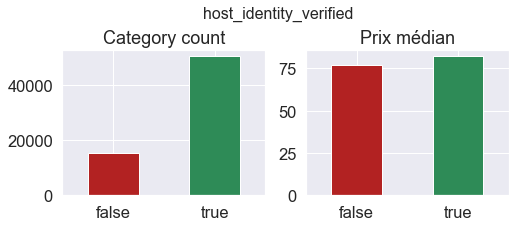

In [79]:
binary_count_and_price_plot('host_identity_verified')

**Instant booking**

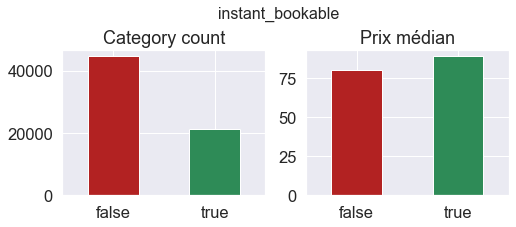

0    0.676722
1    0.323278
Name: instant_bookable, dtype: float64


In [80]:
binary_count_and_price_plot('instant_bookable')
print(df.instant_bookable.value_counts(normalize=True))

**Amenities**

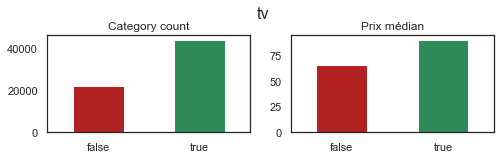

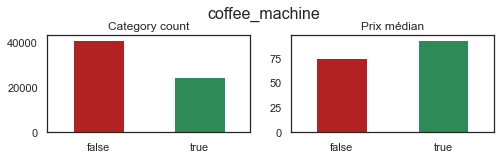

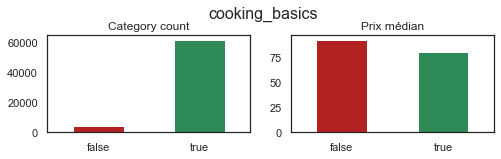

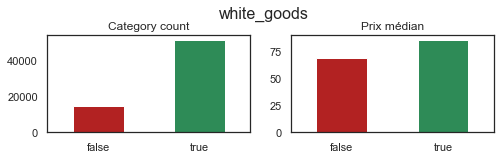

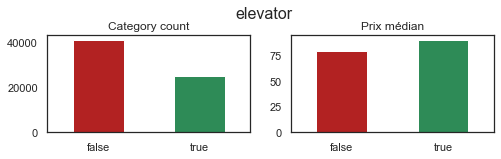

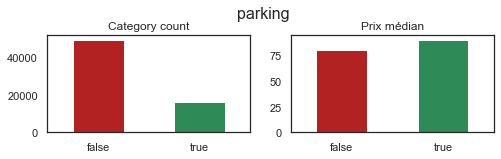

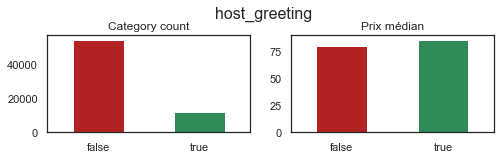

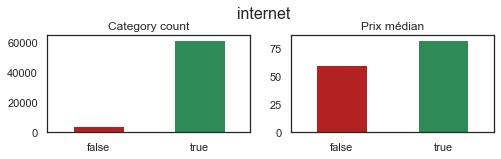

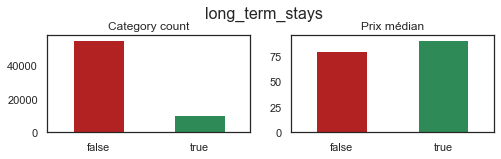

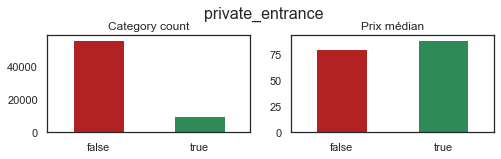

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (2).

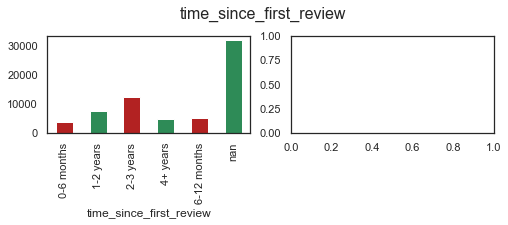

In [95]:
for col in df.iloc[:,31:-2].columns:
    binary_count_and_price_plot(col, figsize=(8,2))

# Preparing the data for modeling

**Dropping columns and assessing multi-collinearity**

Les variables catégorielles seront maintenant encodés

In [82]:
transformed_df = pd.get_dummies(df)

In [83]:
def multi_collinearity_heatmap(df, figsize=(11,9)):

    sns.set(style="white")

    corr = df.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=figsize)

    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

C:\Users\oulad\AppData\Local\Temp/ipykernel_16692/2961596392.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


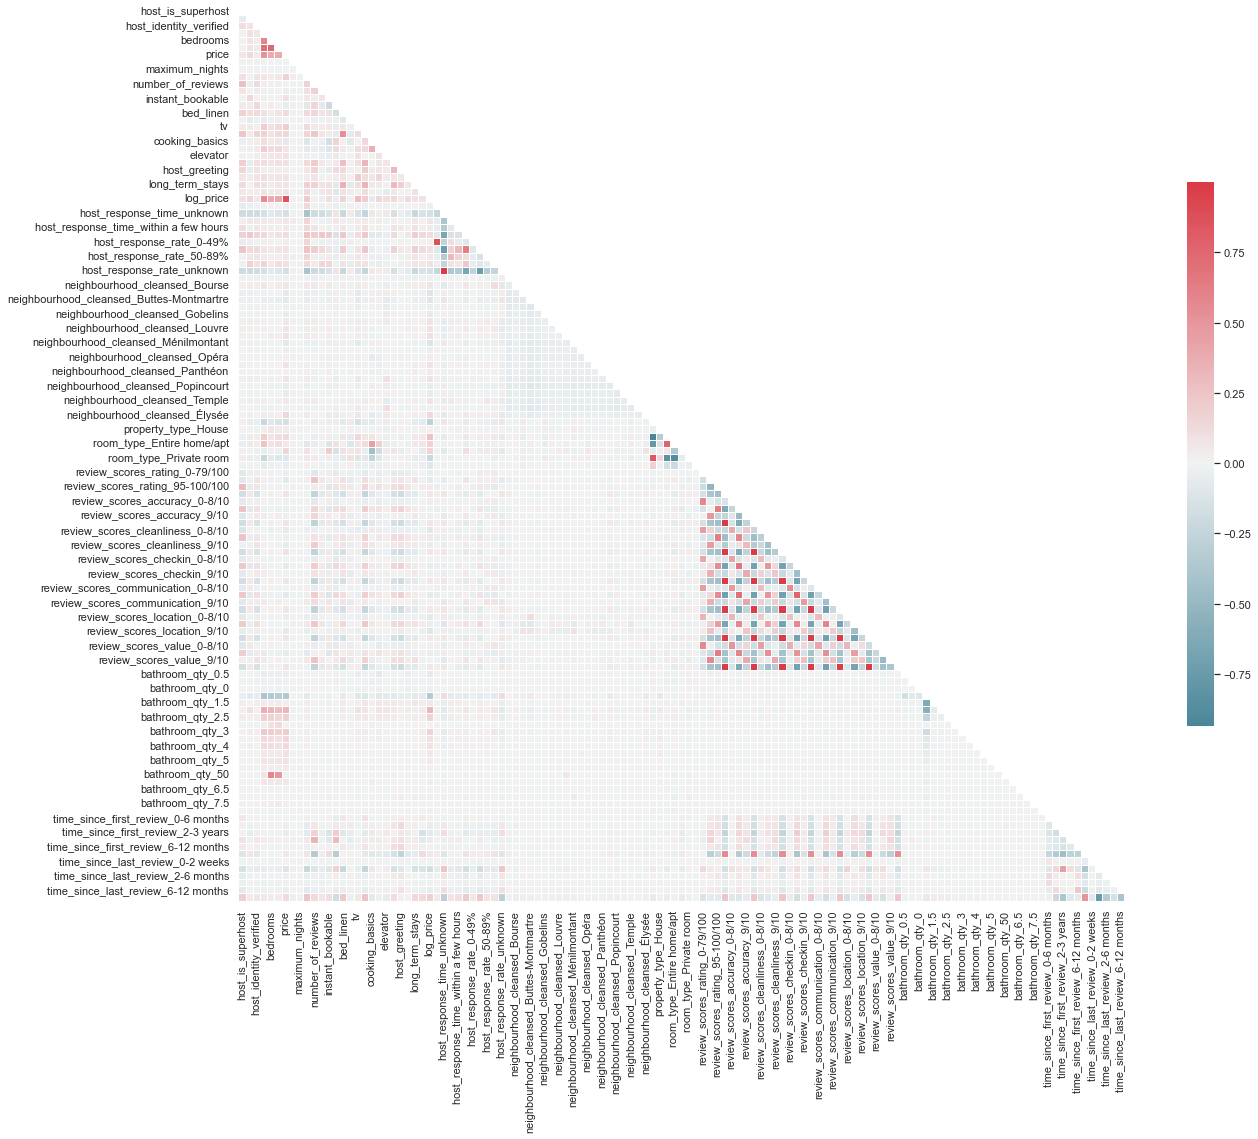

In [84]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

C:\Users\oulad\AppData\Local\Temp/ipykernel_16692/2961596392.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


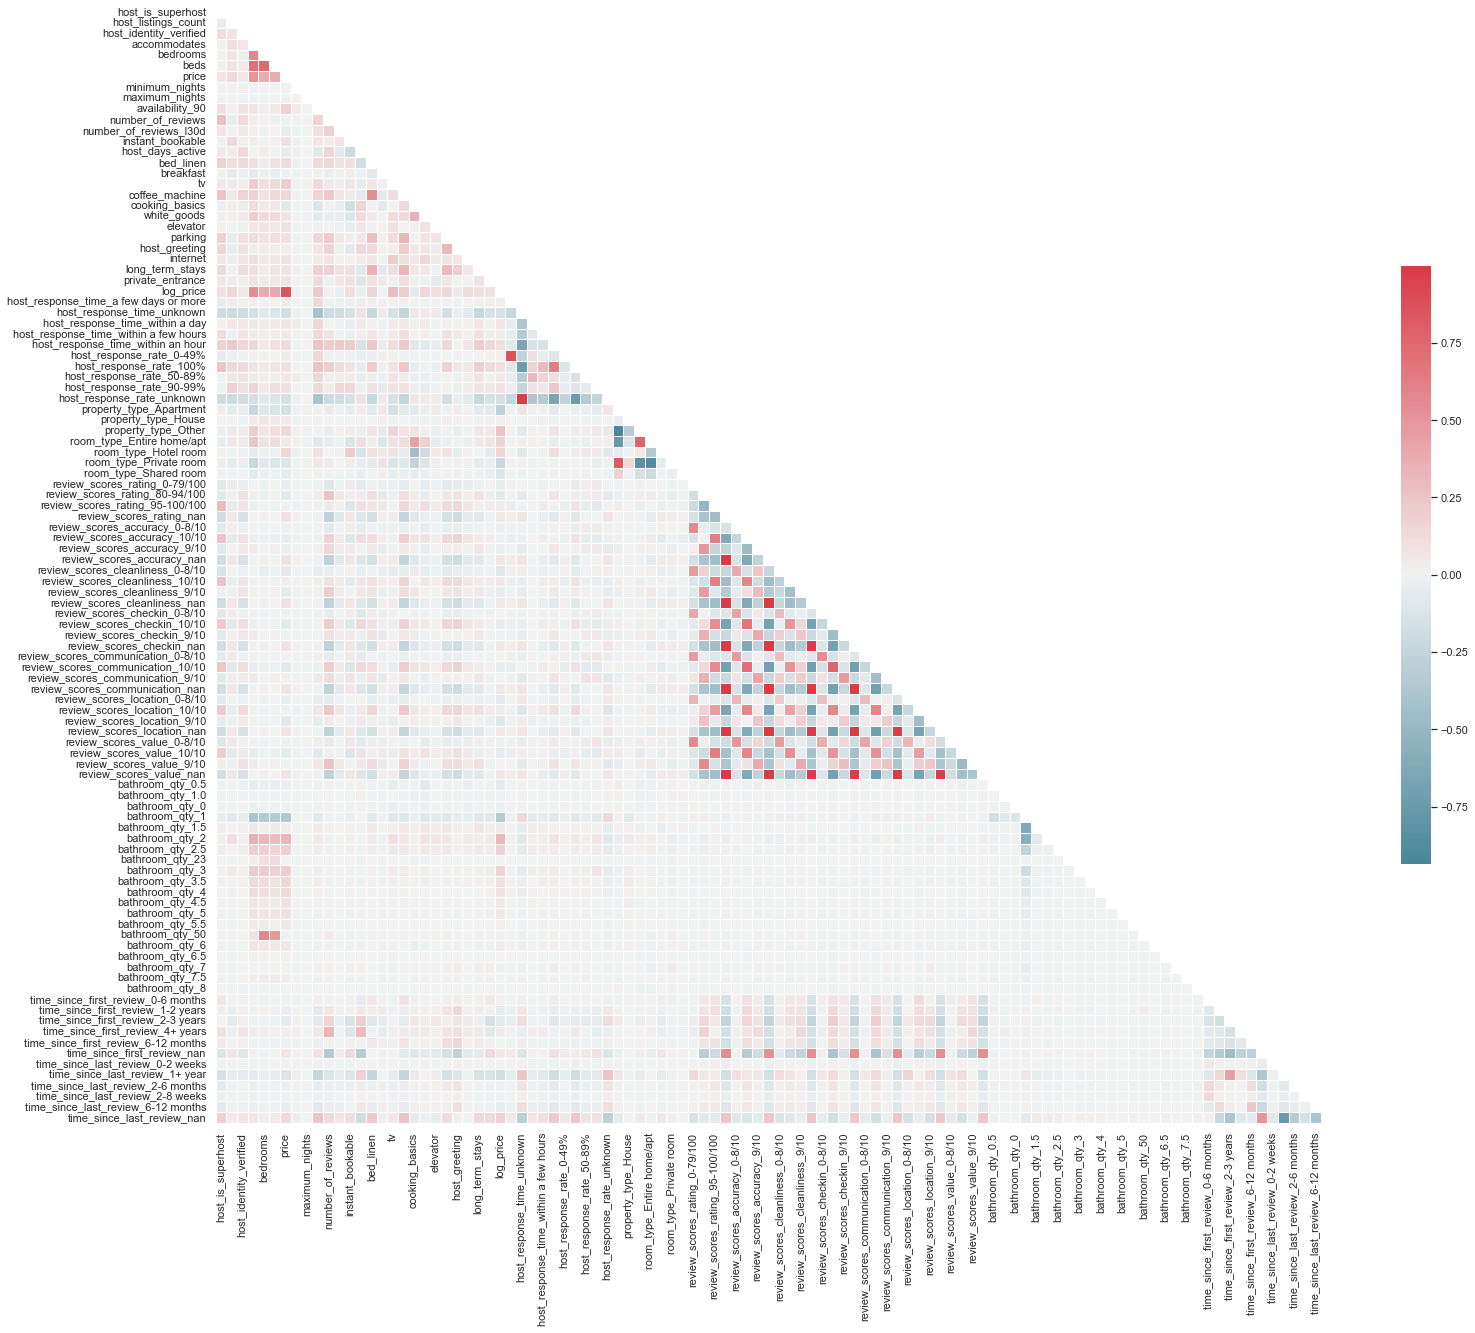

In [85]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood_cleansed')]), axis=1), figsize=(25,22))

In [86]:
to_drop = ['beds',
           'bedrooms', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

In [87]:
transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('bathroom')]), axis=1 , inplace=True)

C:\Users\oulad\AppData\Local\Temp/ipykernel_16692/2961596392.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


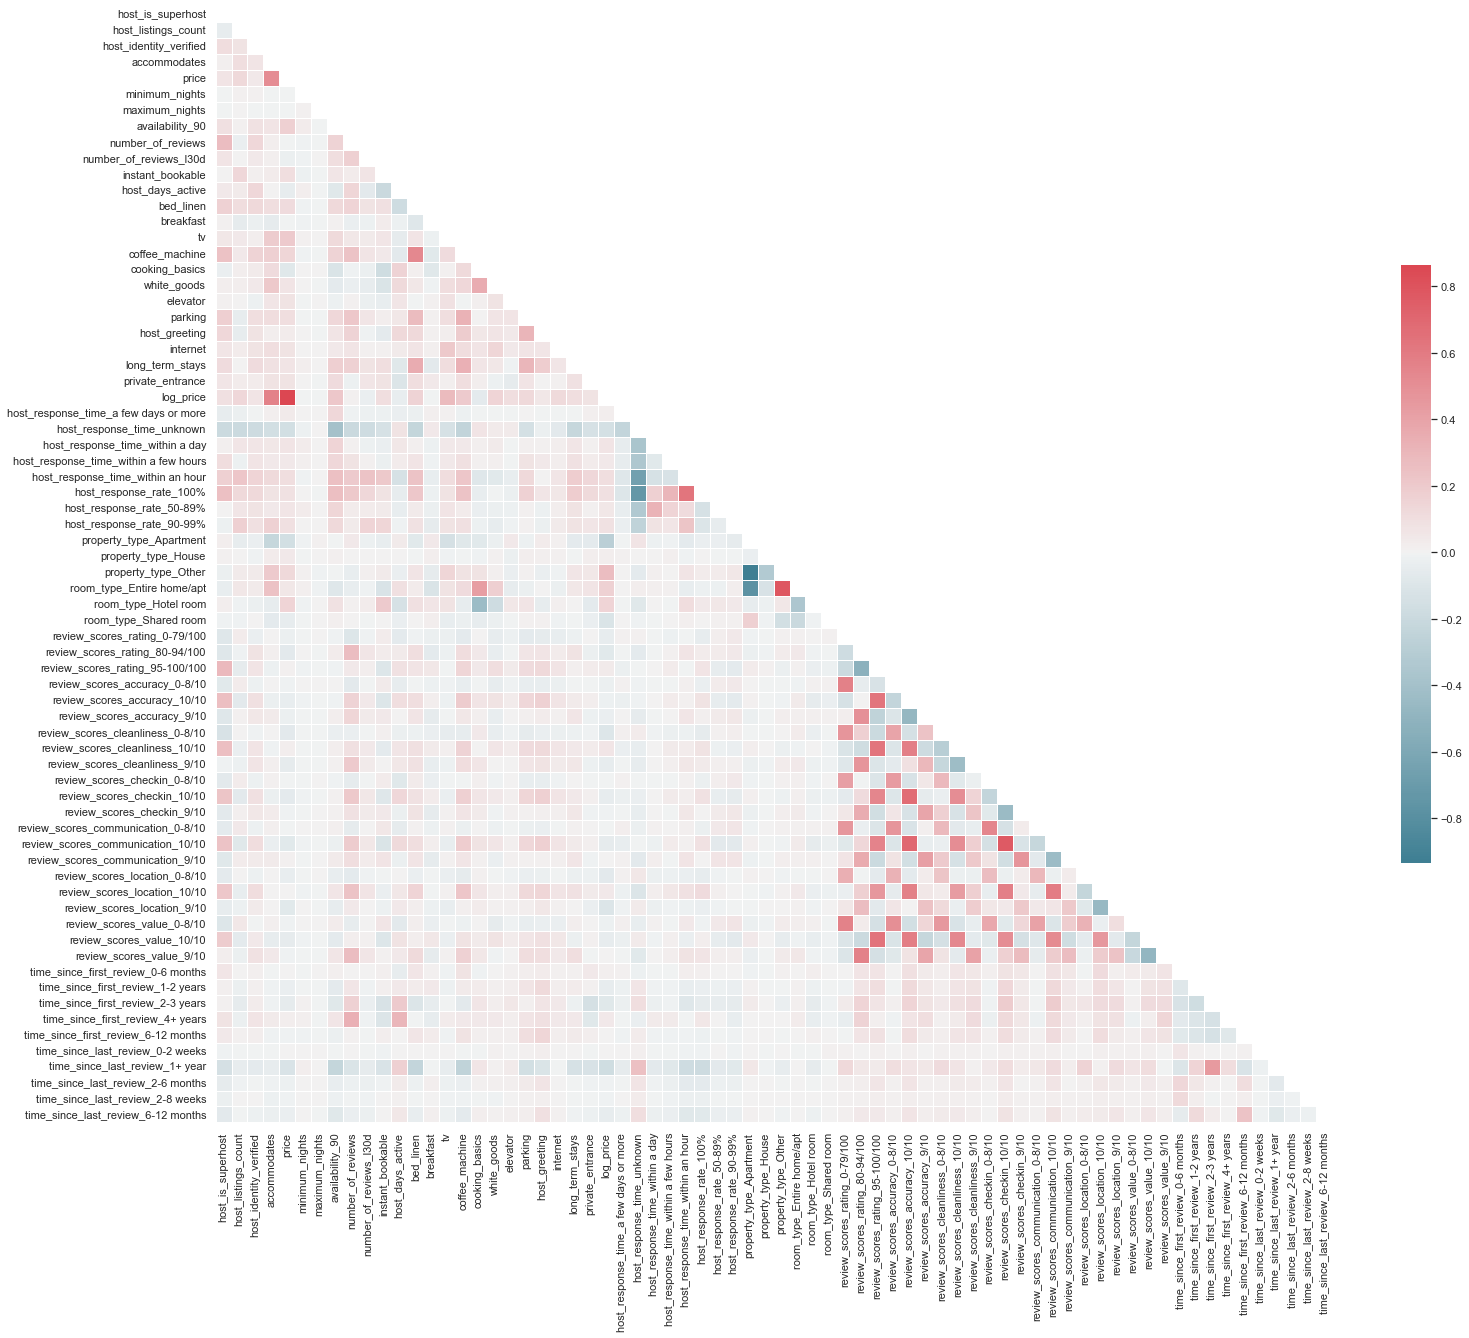

In [88]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood_cleansed')]), axis=1), figsize=(25,22))

There are still some fairly strong correlations between highly rated properties of different reviews categories - i.e. if a property gets a 10/10 for one category, it is likely to get a 10/10 for other categories. However, these will be left in for now and can be experimented with later to see if removing them improves the model.

**Standardising and normalising**

Other than availability_90 and host_days_active, the remaining numerical features are all postively skewed and could benefit from log transformation.

In [89]:
numerical_columns = ['accommodates', 'availability_90', 'host_days_active', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price']

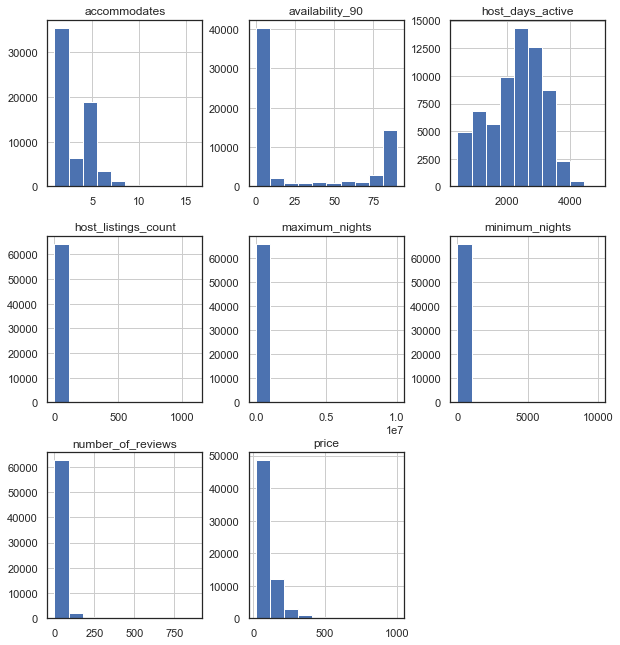

In [90]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [91]:
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

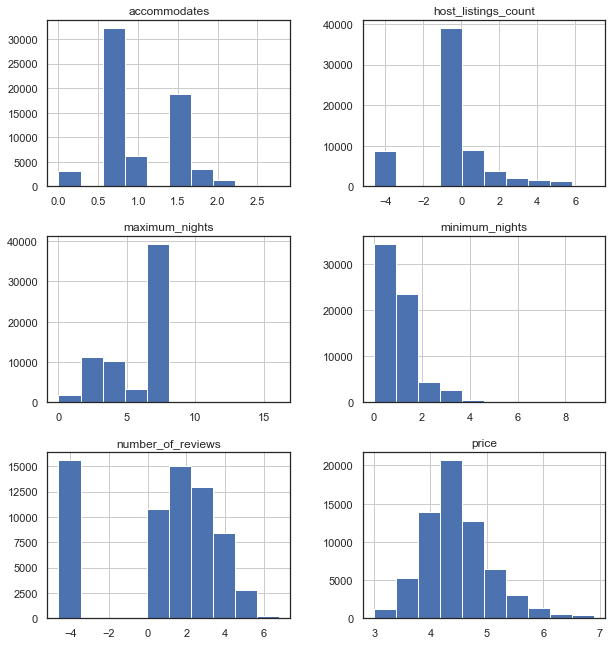

In [92]:
transformed_df[numerical_columns].hist(figsize=(10,11));

Enfin, les caractéristiques prédictives X et la caractéristique cible y peuvent être séparées, et X sera mis à l'échelle. StandardScaler de sklearn sera utilisé.

In [94]:
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>)

***

# Prediction

Les mesures d'évaluation utilisées seront l'erreur quadratique moyenne (pour la perte) et le r au carré (pour la précision).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Model 1: XGBoost

 Le modèle XGBoost sera utilisé pour prédire les features importantes. Cette méthode fournit très probablement la meilleure précision réalisable à l'aide de modèles d'apprentissage automatique (hormis les petites augmentations de précision possibles grâce au réglage des hyperparamètres) en raison des performances supérieures de XGBoost.

In [ ]:

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))


Training MSE: 0.1074
Validation MSE: 0.1475

Training r2: 0.7129
Validation r2: 0.6116


In [ ]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
review_scores_accuracy_10/10,0.001575
time_since_first_review_6-12 months,0.001606
time_since_last_review_2-8 weeks,0.001621
review_scores_checkin_9/10,0.001785
time_since_first_review_1-2 years,0.001811
review_scores_checkin_0-8/10,0.001814
time_since_last_review_2-6 months,0.001821
host_identity_verified,0.001835
host_response_time_within a day,0.001890
time_since_first_review_0-6 months,0.001938


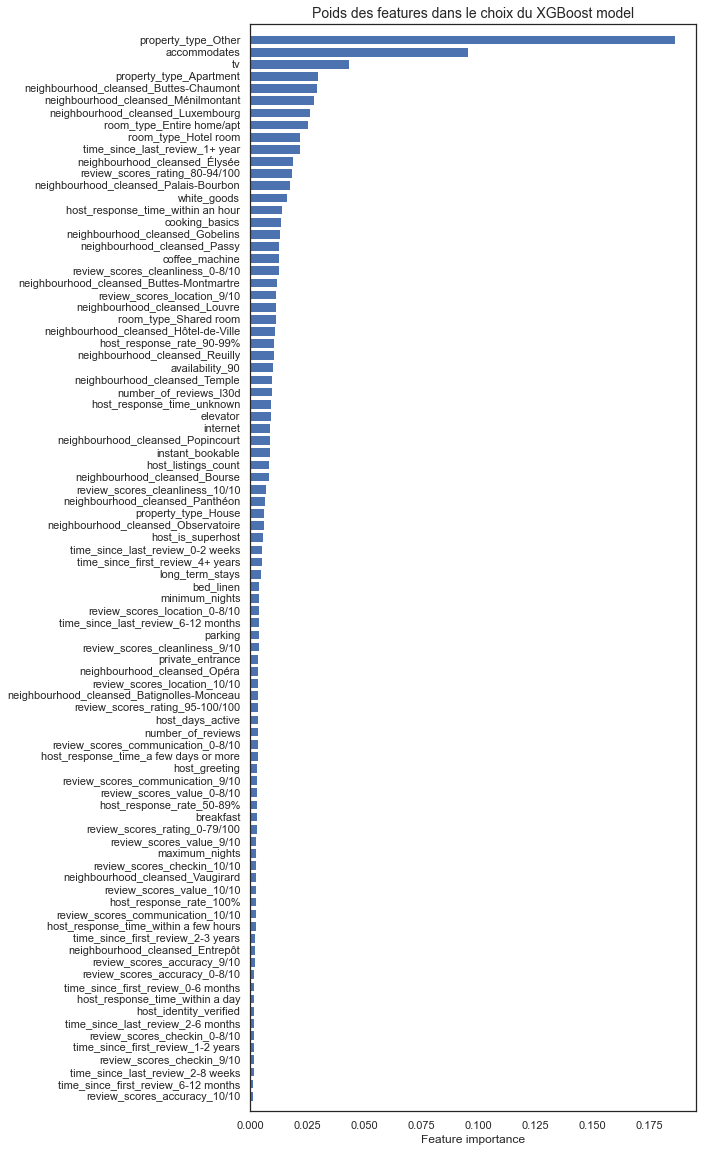

In [ ]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Poids des features dans le choix du XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

## SGD Regressor

In [ ]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train, y_train)

training_preds_sgd_reg = sgd_reg.predict(X_train)
val_preds_sgd_reg = sgd_reg.predict(X_test)

print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_sgd_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_sgd_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_sgd_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_sgd_reg),4))


Training MSE: 0.1821
Validation MSE: 0.1894

Training r2: 0.5129
Validation r2: 0.5012
